In [2]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES



from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [3]:
run ../util/setupConsole_su

In [4]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [5]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [6]:
# tx_era5 = xr.open_mfdataset('%s/daily/tasmax_*.nc'%dirEra5)
# tx_era5_mean = tx_era5.mean(dim='time')
# # tx_era5_mean.compute()
# tx_era5_mean.to_netcdf('era5_tasmax_mean.nc')

In [7]:
tw_era5_mean = xr.open_dataset('era5_tw_max_mean.nc')
tw_era5_mean.load()

tx_era5_mean = xr.open_dataset('era5_tasmax_mean.nc')
tx_era5_mean.load()
tx_era5_mean['mx2t'] -= 273.15

In [8]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [9]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1


In [10]:
tw_era5_mean['tw'] = tw_era5_mean['tw'].where(land_sea_mask_binary, np.nan)
tw_era5_mean['tw'] = tw_era5_mean['tw'].sel(latitude=slice(60,-60))

In [11]:
tw = xr.open_dataset('era5_tw_max_trends_by_decile_new.nc')
tw.load()
tw['tw_trend'] = tw['tw_trend'].sel(latitude=slice(60,-60))
tw['tw_trend_p_value'] = tw['tw_trend_p_value'].sel(latitude=slice(60,-60))

In [12]:
tx = xr.open_dataset('era5_tasmax_trends_by_decile.nc')
tx.load()
tx['tasmax_trend'] = tx['tasmax_trend'].sel(latitude=slice(60,-60))
tx['tasmax_trend_p_value'] = tx['tasmax_trend_p_value'].sel(latitude=slice(60,-60))

In [13]:
p1 = 100
p2 = 80

tw_100_1d = tw.tw_trend[:,:,p1].values.reshape(tw.tw_trend[:,:,p1].size)
tw_100_p_1d = tw.tw_trend_p_value[:,:,p1].values.reshape(tw.tw_trend_p_value[:,:,p1].size)

tw_50_1d = tw.tw_trend[:,:,p2].values.reshape(tw.tw_trend[:,:,p2].size)
tw_50_p_1d = tw.tw_trend_p_value[:,:,p2].values.reshape(tw.tw_trend_p_value[:,:,p2].size)

tw_amp = tw.tw_trend[:,:,p1]-tw.tw_trend[:,:,p2]
tw_mean_1d = tw_era5_mean.tw.values.reshape(tw_era5_mean.tw.values.size)
tw_amp_1d = tw_amp.values.reshape(tw_amp.values.size)
tw_amp_sig_1d = tw_amp_1d[np.where((tw_100_p_1d<0.05) & (tw_50_p_1d<0.05))[0]]


tx_100_1d = tx.tasmax_trend[:,:,p1].values.reshape(tx.tasmax_trend[:,:,p1].size)
tx_50_1d = tx.tasmax_trend[:,:,p2].values.reshape(tx.tasmax_trend[:,:,p2].size)
tx_amp = tx.tasmax_trend[:,:,p1]-tx.tasmax_trend[:,:,p2]
tx_mean_1d = tx_era5_mean.mx2t.values.reshape(tx_era5_mean.mx2t.values.size)
tx_amp_1d = tx_amp.values.reshape(tx_amp.values.size)



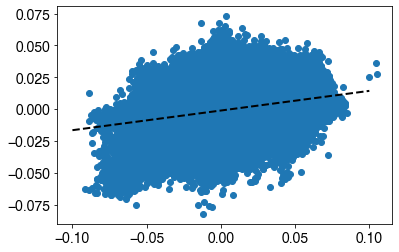

In [336]:
nn = np.where((~np.isnan(tx_amp_1d)) & (~np.isnan(tw_amp_1d)))[0]
X = sm.add_constant(tx_amp_1d[nn])
mdl = sm.OLS(tw_amp_1d[nn], X).fit()
plt.scatter(tx_amp_1d, tw_amp_1d)
x1 = -.1
x2 = .1
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2)
# mdl.summary()

In [17]:
land_pct_tw_amp = []
land_pct_tx_amp = []

temp_bins = np.arange(-10, 41)

for tw_mean_thresh in temp_bins:
    tw_100_tmp_1d = tw_100_1d.copy()
    tw_100_tmp_1d[tw_mean_1d < tw_mean_thresh] = np.nan
    tw_100_tmp_1d[tw_100_p_1d > 0.1] = np.nan
    
    tw_50_tmp_1d = tw_50_1d.copy()
    tw_50_tmp_1d[tw_mean_1d < tw_mean_thresh] = np.nan
    tw_50_tmp_1d[tw_50_p_1d > 0.1] = np.nan
    
    nn = np.where((~np.isnan(tw_100_tmp_1d)) & (~np.isnan(tw_50_tmp_1d)))[0]
    if nn.size > 10:
        land_pct_tw_amp.append(np.where(tw_100_tmp_1d[nn]>tw_50_tmp_1d[nn])[0].size/nn.size)
    else:
        land_pct_tw_amp.append(np.nan)
        
for tx_mean_thresh in temp_bins:
    tx_100_tmp_1d = tx_100_1d.copy()
    tx_100_tmp_1d[tx_mean_1d < tx_mean_thresh] = np.nan
    tx_100_tmp_1d[tx_100_p_1d > 0.1] = np.nan
    
    tx_50_tmp_1d = tx_50_1d.copy()
    tx_50_tmp_1d[tx_mean_1d < tx_mean_thresh] = np.nan
    tx_50_tmp_1d[tx_50_p_1d > 0.1] = np.nan
    
    nn = np.where((~np.isnan(tx_100_tmp_1d)) & (~np.isnan(tx_50_tmp_1d)))[0]
    if nn.size > 10:
        land_pct_tx_amp.append(np.where(tx_100_tmp_1d[nn]>tx_50_tmp_1d[nn])[0].size/nn.size)
    else:
        land_pct_tx_amp.append(np.nan)

NameError: name 'tx_100_p_1d' is not defined

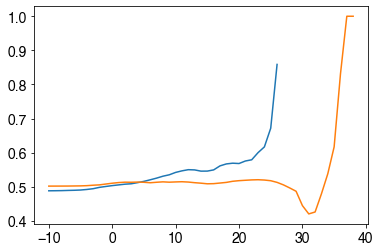

In [325]:
plt.plot(temp_bins, land_pct_tw_amp)
plt.plot(temp_bins, land_pct_tx_amp)

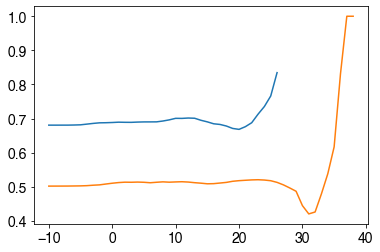

In [16]:
plt.plot(temp_bins, land_pct_tw_amp)
plt.plot(temp_bins, land_pct_tx_amp)

In [326]:
s = []
for p in np.arange(0, 101, 10):
    tw_1_1d = t.tw_trend[:,:,100].values.reshape(t.tw_trend[:,:,100].size)
    tw_2_1d = t.tw_trend[:,:,p].values.reshape(t.tw_trend[:,:,p].size)

    nn = np.where((~np.isnan(tw_1_1d)) & (~np.isnan(tw_2_1d)))[0]
    X = sm.add_constant(tw_2_1d[nn])
    mdl = sm.OLS(tw_1_1d[nn], X).fit()
    s.append(mdl.params[1])

Text(0, 0.5, 'TW 100th percentile trend')

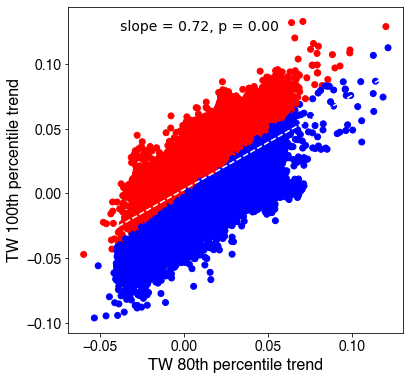

In [327]:
nn = np.where((~np.isnan(tw_100_1d)) & (~np.isnan(tw_50_1d)))[0]
X = sm.add_constant(tw_50_1d[nn])
mdl = sm.OLS(tw_100_1d[nn], X).fit()

font = FontProperties(family='Arial', size=14)

x1 = np.nanmin(tw_50_1d)
x2 = np.nanmax(tw_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(tw_50_1d[nn], tw_100_1d[nn], c=(tw_100_1d[nn]>tw_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [0,0], '-k', lw=2)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('TW %dth percentile trend'%p2)
plt.ylabel('TW %dth percentile trend'%p1)

Text(0, 0.5, 'Tx 100th percentile trend')

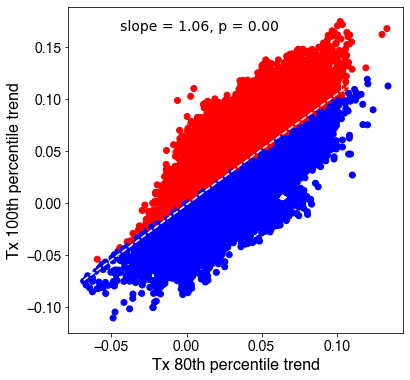

In [328]:
nn = np.where((~np.isnan(tx_100_1d)) & (~np.isnan(tx_50_1d)))[0]
X = sm.add_constant(tx_50_1d[nn])
mdl = sm.OLS(tx_100_1d[nn], X).fit()

font = FontProperties(family='Arial', size=14)

x1 = np.nanmin(tx_50_1d)
x2 = np.nanmax(tx_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(tx_50_1d[nn], tx_100_1d[nn], c=(tx_100_1d[nn]>tx_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [0,0], '-k', lw=2)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('Tx %dth percentile trend'%p2)
plt.ylabel('Tx %dth percentile trend'%p1)

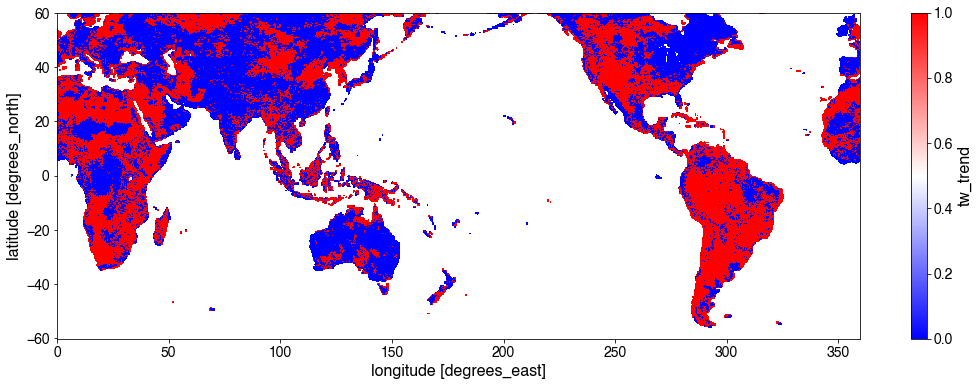

In [329]:
tw_amp_binary = tw_amp>0
tw_amp_land_only = tw_amp_binary.where(land_sea_mask_binary, np.nan)
tw_amp_land_only = tw_amp_land_only.where(~np.isnan(tw_amp), np.nan)
tw_amp_land_only = tw_amp_land_only.sel(latitude=slice(60,-60))
tw_amp_land_only.plot(cmap='bwr', figsize=(18,6))

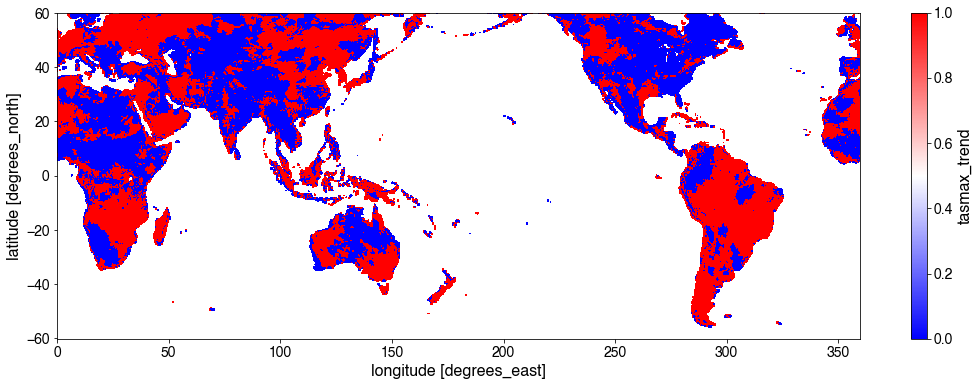

In [330]:
tx_amp_binary = tx_amp>0
tx_amp_land_only = tx_amp_binary.where(land_sea_mask_binary, np.nan)
tx_amp_land_only = tx_amp_land_only.where(~np.isnan(tx_amp), np.nan)
tx_amp_land_only = tx_amp_land_only.sel(latitude=slice(60,-60))
tx_amp_land_only.plot(cmap='bwr', figsize=(18,6))

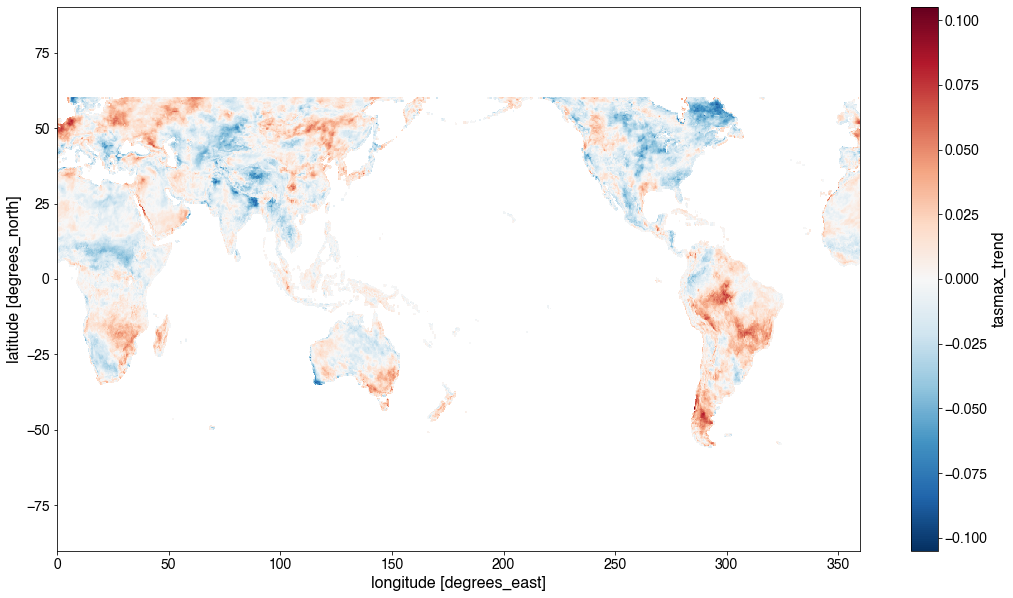

In [331]:
tx_amp.plot(figsize=(18,10))